The goal of this notebook:

1. Utilize a statistic (derived from a hypothesis test) to measure change within each polarization of a time series of SAR images.
2. Use threshold determined from a pair to determine change throughout a time series of L-band imagery.

In [1]:
import rasterio
import numpy
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from astropy.convolution import convolve
from tqdm import tqdm
import matplotlib.patches as mpatches
import geopandas as gpd

from rscube import (get_geopandas_features_from_array,
                    filter_binary_array_by_min_size, 
                    scale_img,
                    polygonize_array_to_shapefile
                   )

# Setup Paths to Data

In [2]:
DATA_DIR = Path(f'data/asf_data_reprojected/')
DATA_DIR.exists()

True

In [3]:
hh_paths = sorted(list(DATA_DIR.glob('*/*hh*.tif')))
hv_paths = sorted(list(DATA_DIR.glob('*/*hv*.tif')))
vv_paths = sorted(list(DATA_DIR.glob('*/*vv*.tif')))
hv_paths

[PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20070830.tif'),
 PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20080717.tif'),
 PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20100723.tif'),
 PosixPath('data/asf_data_reprojected/hv/ALOS1_RTC_hv_20100907.tif')]

In [4]:
CHANGE_DIR = Path('out/change_maps')
CHANGE_DIR.mkdir(exist_ok=True, parents=True)

This will be a trehold associated with each polarization. We can save this if we want to continue such a threshold for the time series in this area.

In [5]:
if 'THRESHOLD_DICT' not in locals():
    # keys = 'hh', 'hv', 'vv'
    # values = threshold associated with the change statistics
    THRESHOLD_DICT = {}
THRESHOLD_DICT

{}

# Polarization

In [6]:
POL = 'hv'

# Read Tifs

In [7]:
with rasterio.open(hv_paths[0]) as ds:
    profile = ds.profile

In [8]:
def read_arr(path):
    with rasterio.open(path) as ds:
        arr = (ds.read(1))
    return arr
hv_ts = list(map(read_arr, hv_paths))
hh_ts = list(map(read_arr, hh_paths))
vv_ts = list(map(read_arr, vv_paths))

# Change Statistic and Inspection

We use a patch change detector elaborated in this [paper](https://www.researchgate.net/publication/229390532_How_to_Compare_Noisy_Patches_Patch_Similarity_Beyond_Gaussian_Noise) and simply add this metric channel by channel.
$$
s_{p} = \log\left(\frac{xy}{(x + y)^2} \right)
$$
where $x$ and $y$ are the backscatter values for a given polarization $p$ at a pixel for different times. We compute $s_p$ within a patch using a convolution.

In [48]:
PATCH_SIZE = 7

In [10]:
def get_change_statistic(img_0, img_1, patch_size=PATCH_SIZE, mask=None):

    X_0 = np.clip(img_0, 1e-3, 1)
    X_1 = np.clip(img_1, 1e-3, 1)
    
    glr = np.log(X_0 * X_1 / (X_0 + X_1)**2)

    if mask is not None:
        glr[mask] = np.nan
    
    kernel = np.ones((patch_size, patch_size))
    change_statistic = convolve(glr,
                                kernel,
                                boundary='extend',
                                nan_treatment='interpolate',
                                normalize_kernel=True,
                                preserve_nan=True)
       
    return change_statistic

We need a basic water mask, which we obtain via the HV image.

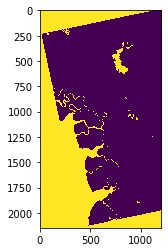

In [11]:
# Ignore the nodata areas and low db (specifically below -22)
mask = np.isnan(hv_ts[0]) | (10 * np.log10(hv_ts[0]) < -22)

# Remove small land areas from water
mask = 1 - filter_binary_array_by_min_size(1 - mask.astype(int), 140).astype(bool)

# Remove small water areas from land
mask = filter_binary_array_by_min_size(mask.astype(int), 140).astype(bool)
plt.imshow(mask, interpolation='none')

Now, we are going to add the mangrove mask.

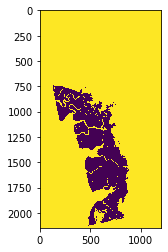

In [12]:
with rasterio.open(DATA_DIR/'mangrove_mask.tif') as ds:
    mangrove_mask = ~(ds.read(1).astype(bool))

mask = mask | mangrove_mask

plt.imshow(mask, interpolation='none')

In [13]:
p = profile.copy()
p['dtype'] = 'uint8'
p['nodata'] = None
with rasterio.open('out/mask.tif', 'w', **p) as ds:
    ds.write(mask.astype(np.uint8), 1)

In [14]:
IND_0 = 0
IND_1 = 2

In [15]:
def get_ts(pol):
    if pol == 'hh':
        ts = hh_ts
    elif pol == 'hv':
        ts = hv_ts
    elif pol == 'vv':
        ts = vv_ts
    else:
        raise ValueError('choose hh, hv, vv')
    return ts

In [16]:
ts = get_ts(POL)

In [17]:
change_statistic = get_change_statistic(ts[IND_0], ts[IND_1],
                                        mask = mask
                                        )

/Users/cmarshak/anaconda3/envs/rscube/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


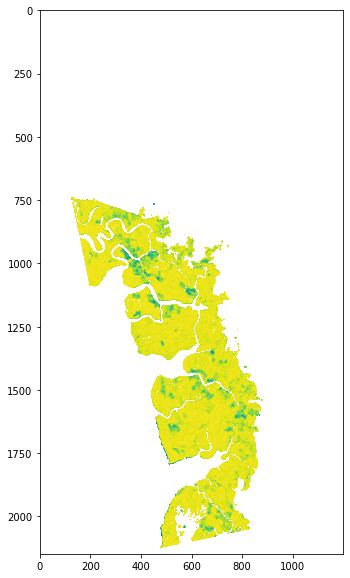

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(change_statistic, interpolation='none')

In [19]:
sy = np.s_[1_000:2_000]
sx = np.s_[200:700]

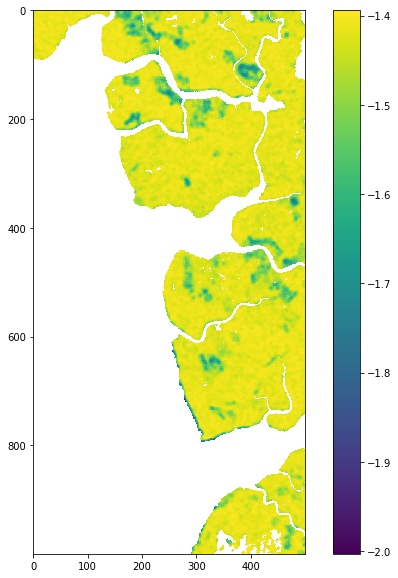

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(change_statistic[sy, sx], interpolation='none')
plt.colorbar()

In [21]:
PERCENTILE = 20

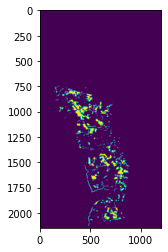

In [22]:
T = np.nanpercentile(change_statistic, PERCENTILE)

data_mask = ~np.isnan(change_statistic)
C = np.zeros(change_statistic.shape)
C[data_mask] = (change_statistic[data_mask] < T)

plt.imshow(C, interpolation=None)

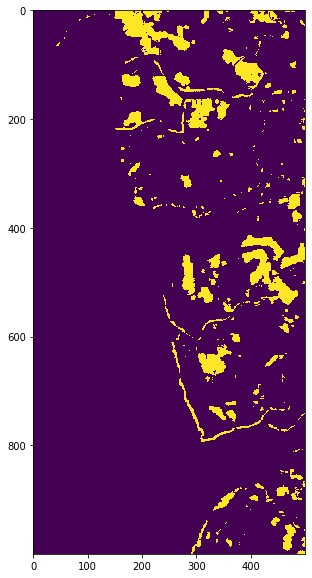

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(C[sy, sx], interpolation='none')


In [24]:
SIZE = PATCH_SIZE**2
def morphological_filter(img):
    return filter_binary_array_by_min_size(img, SIZE)

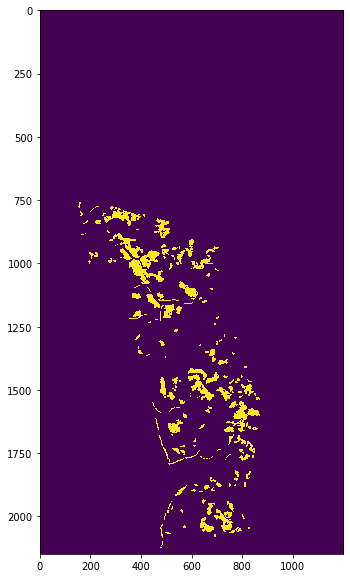

In [25]:
plt.figure(figsize=(10, 10))

C = morphological_filter(C)
plt.imshow(morphological_filter(C), interpolation='none')

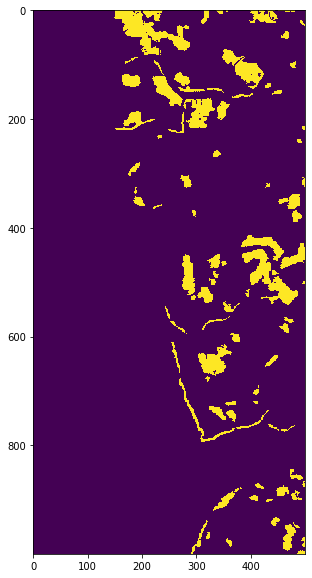

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(C[sy, sx], interpolation='none')

In [27]:
THRESHOLD_DICT[POL] = T

In [28]:
DEST_DIR = (CHANGE_DIR/'_test_pairs')
DEST_DIR.mkdir(exist_ok = True, parents=True)
polygonize_array_to_shapefile(C, profile, DEST_DIR/f'{POL}_{IND_0}_{IND_1}', mask=~(C.astype(bool)))


# Inspecting Change Across the Time Series

In [29]:
n = len(ts)
pol_thresh = THRESHOLD_DICT[POL]

In [30]:
change_statistic_ts = [get_change_statistic(ts[i], 
                                            ts[i + 1],
                                            mask=mask) 
                       for i in tqdm(range(n-1))]

  0%|          | 0/3 [00:00<?, ?it/s]/Users/cmarshak/anaconda3/envs/rscube/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
100%|██████████| 3/3 [00:00<00:00,  8.60it/s]


Let's make sure the histogram roughly is well behaved across pairs.

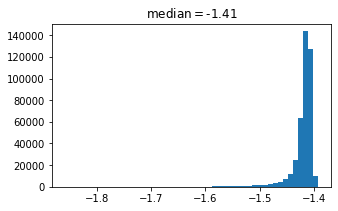

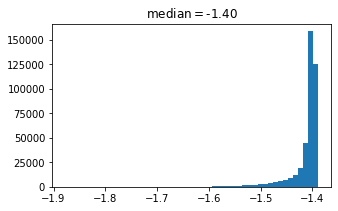

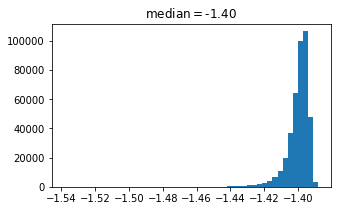

In [31]:
for cs in change_statistic_ts:
    plt.figure(figsize=(5, 3))
    data = (cs[~np.isnan(cs)])
    plt.hist(data, bins=50)
    plt.title(f'median$=${np.median(data):1.2f}')

We now apply the threshold and morphological filter to get a change map.

In [32]:
def change_determination(change_statistic):
    data_mask = ~np.isnan(change_statistic)
    C = np.zeros(change_statistic.shape)
    C[data_mask] = (change_statistic[data_mask] < pol_thresh)
    C = morphological_filter(C)
    return C

change_ts = list(map(change_determination, tqdm(change_statistic_ts)))

100%|██████████| 3/3 [00:00<00:00,  5.36it/s]


Let's check the results for different indices.

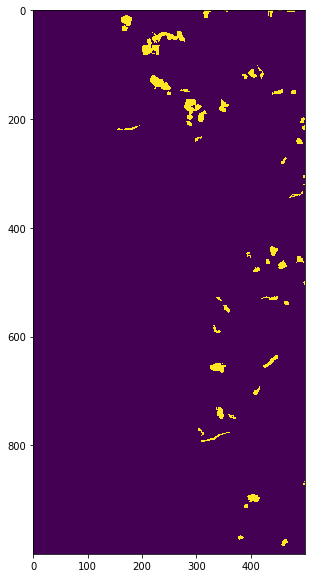

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(change_ts[0][sy, sx], interpolation='none')

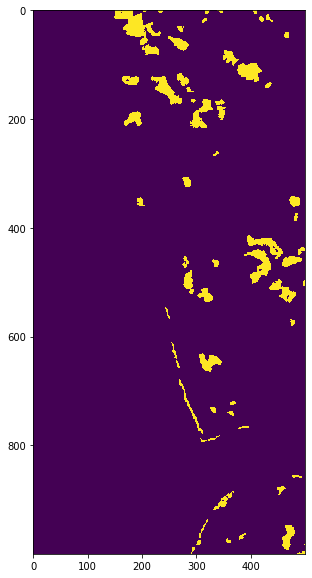

In [34]:
plt.figure(figsize=(10, 10))
plt.imshow(change_ts[1][sy, sx], interpolation='none')

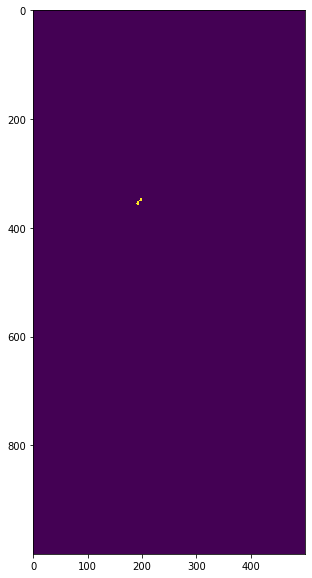

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(change_ts[2][sy, sx], interpolation='none')

## Save Each Change Map

We are going to create a dictionary in which each the `index in the time series + 1 --> date`. It's based on the name convention of how we named the images. Note strings are also lists in python so we can grab the pieces of the string name that are relevant.

In [36]:
hv_names = list(map(lambda path: path.name, hv_paths))
hv_names

['ALOS1_RTC_hv_20070830.tif',
 'ALOS1_RTC_hv_20080717.tif',
 'ALOS1_RTC_hv_20100723.tif',
 'ALOS1_RTC_hv_20100907.tif']

In [37]:
def format_date(date_str):
    return f'{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}'

date_dict = {(k + 1): format_date(str(path.name)[13:21])  for (k, path) in enumerate(hv_paths[1:])}
date_dict[0] = 'No Change'
date_dict

{1: '2008-07-17', 2: '2010-07-23', 3: '2010-09-07', 0: 'No Change'}

Now, we will write a shapefile for each pair as well as saving a binary image (tif file) of the same results.

In [38]:
DEST_DIR = (CHANGE_DIR/POL)
DEST_DIR.mkdir(exist_ok = True, parents=True)

TIF_DIR = DEST_DIR/'tifs'
TIF_DIR.mkdir(exist_ok = True, parents=True)

p = profile.copy()
p['dtype'] = 'uint8'
p['nodata'] = None

def write_pairwise_changes(k):
    C = change_ts[k]
    date_str = date_dict[k+1]
    dest_path_shp = DEST_DIR/f'{POL}_{k}_{date_str}'
    dest_path_tif = TIF_DIR/f'{POL}_{k}_{date_str}.tif'
    polygonize_array_to_shapefile(C, p, dest_path_shp, mask=~(C.astype(bool)))
    with rasterio.open(dest_path_tif, 'w', **p) as ds:
        ds.write(C.astype(np.uint8), 1)
    return dest_path_shp, dest_path_tif

In [39]:
list(map(write_pairwise_changes, tqdm(range(n-1))))

100%|██████████| 3/3 [00:00<00:00, 20.18it/s]


[(PosixPath('out/change_maps/hv/hv_0_2008-07-17'),
  PosixPath('out/change_maps/hv/tifs/hv_0_2008-07-17.tif')),
 (PosixPath('out/change_maps/hv/hv_1_2010-07-23'),
  PosixPath('out/change_maps/hv/tifs/hv_1_2010-07-23.tif')),
 (PosixPath('out/change_maps/hv/hv_2_2010-09-07'),
  PosixPath('out/change_maps/hv/tifs/hv_2_2010-09-07.tif'))]

## Combine Pairwise Changes into Single Change Map

We'll set each change map to an integer corresponding to it's `index + 1` in the time series.

In [40]:
change_map = np.zeros(change_ts[0].shape)
for k in range(len(change_ts)):
    ind = change_ts[k].astype(bool)
    change_map[ind] = (change_ts[k][ind] * (k + 1))

(-0.5, 1199.5, 2147.5, -0.5)

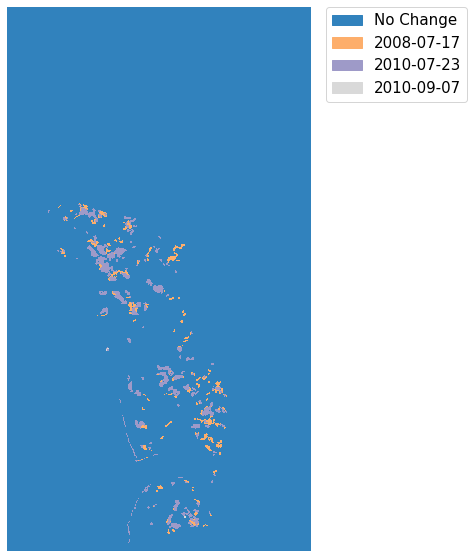

In [41]:
fig, ax = plt.subplots(figsize=(10, 10)) 
cmap='tab20c'
im = ax.imshow(change_map, cmap=cmap, interpolation='none')


values = range(0, len(change_ts) + 1)
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label=f'{date_dict[i]}') for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.axis('off')

(-0.5, 499.5, 999.5, -0.5)

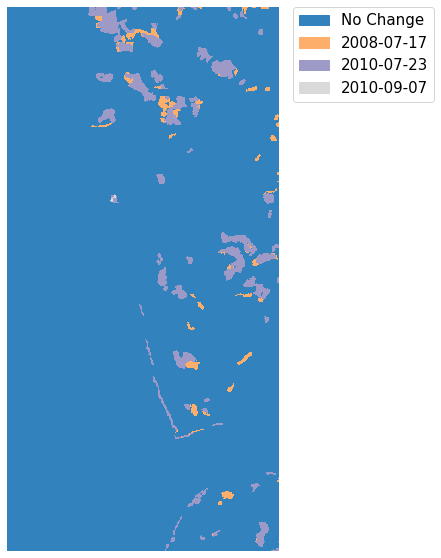

In [42]:
fig, ax = plt.subplots(figsize=(10, 10)) 
im = ax.imshow(change_map[sy, sx], cmap=cmap, interpolation='none')

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.axis('off')

In [43]:
p = profile.copy()
p['dtype'] = 'uint8'
p['nodata'] = 0
with rasterio.open(DEST_DIR/f'{POL}_change_map_combined.tif', 'w', **p) as ds:
    ds.write(change_map.astype(np.uint8), 1)

## Save Combined Change Map as shapefile

In [44]:
m = np.zeros(change_map.shape, dtype=bool)
features = get_geopandas_features_from_array(change_map.astype(np.uint8), profile['transform'], mask=(change_map==0))
df = gpd.GeoDataFrame.from_features(features, crs=profile['crs'])
df.label = df.label.astype('int')
df.head()

,geometry,label
0,"POLYGON ((670104.562 546994.438, 670104.562 54...",1
1,"POLYGON ((670164.562 546964.438, 670164.562 54...",1
2,"POLYGON ((670224.562 546874.438, 670224.562 54...",2
3,"POLYGON ((670404.562 546604.438, 670404.562 54...",1
4,"POLYGON ((670284.562 546484.438, 670284.562 54...",1


In [45]:
def date_trans(label):
    return date_dict[label]

df['date'] = df.label.map(date_trans)
df.head()

,geometry,label,date
0,"POLYGON ((670104.562 546994.438, 670104.562 54...",1,2008-07-17
1,"POLYGON ((670164.562 546964.438, 670164.562 54...",1,2008-07-17
2,"POLYGON ((670224.562 546874.438, 670224.562 54...",2,2010-07-23
3,"POLYGON ((670404.562 546604.438, 670404.562 54...",1,2008-07-17
4,"POLYGON ((670284.562 546484.438, 670284.562 54...",1,2008-07-17


<AxesSubplot:>

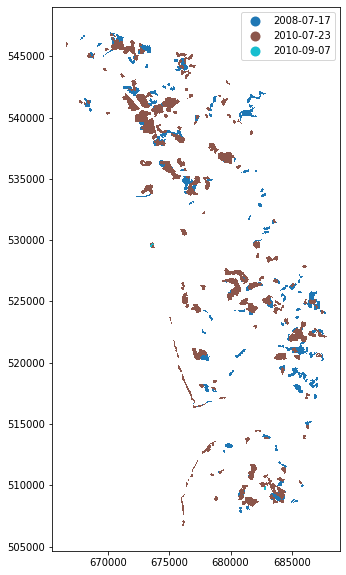

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
df.plot(column='date', ax=ax, legend=True)

In [47]:
df.to_file(DEST_DIR/f'{POL}_change_map_combined_shp')